In [1]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
from SuperpixelCutsPy import *
import scipy as sp
import pandas as pd
# Configs for Notebooks
plt.rcParams["figure.figsize"] = [9,7]
np.set_printoptions(linewidth=200)
np.set_printoptions(suppress=True)

In [24]:
dataset_name = 'Salinas B'
hyperspectral_cube = sp.io.loadmat("data/Salinas_corrected.mat")['salinas_corrected'][35:90,25:175,:] # Load Dataset
ground_truth = sp.io.loadmat("data/Salinas_gt.mat")['salinas_gt'][35:90,25:175]
ground_truth = np.vectorize(lambda x: {0: 0, 4:1, 5:2, 6:3, 7:4, 15:5}[x])(ground_truth)
# ground_truth = np.vectorize(lambda x: {0: 0, 4:1, 5:1, 6:2, 7:3, 8:4, 15:5}[x])(ground_truth)
nx, ny, nb = hyperspectral_cube.shape
print(hyperspectral_cube.shape)

(55, 150, 204)


C:\Users\apopo\AppData\Local\Temp\ipykernel_4780\1828659479.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.cm.get_cmap('RdBu', np.unique(ground_truth).shape[0] - 1)


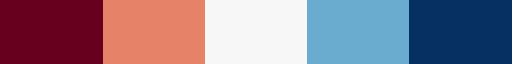

In [25]:
plt.cm.get_cmap('RdBu', np.unique(ground_truth).shape[0] - 1)

C:\Users\apopo\AppData\Local\Temp\ipykernel_4780\606377166.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('RdBu', np.unique(ground_truth).shape[0] - 1)


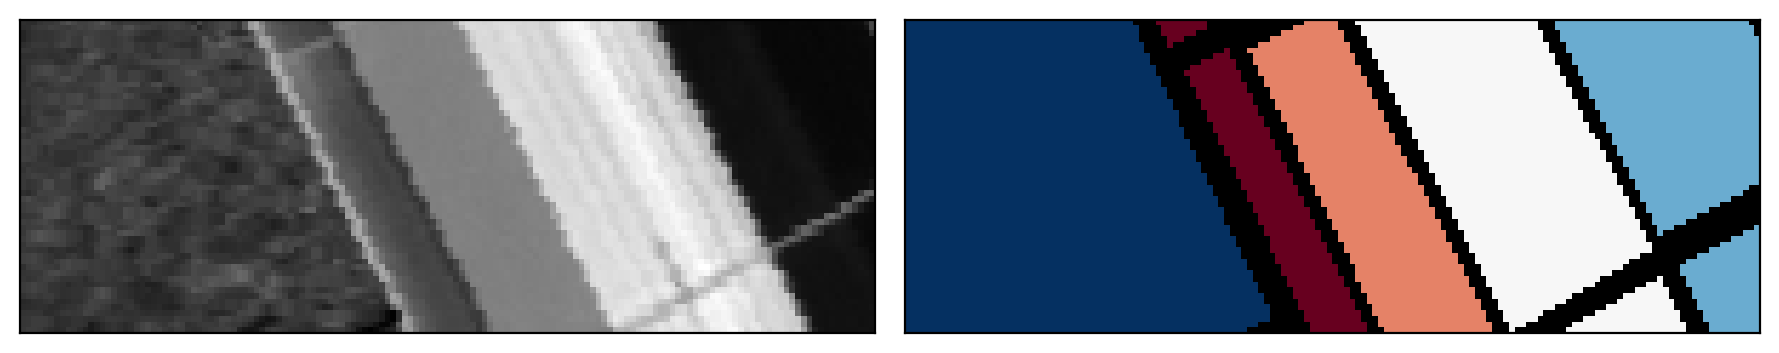

In [26]:
c
cmap.set_bad(color='black') 

fig, ax = plt.subplots(1,2, dpi=200);
ax[0].imshow(hyperspectral_cube[:,:,25], cmap = 'gray');
ax[1].imshow(np.ma.masked_where(ground_truth == 0, ground_truth), cmap = cmap);
ax[0].set_xticks([]);
ax[0].set_yticks([]);
ax[1].set_xticks([]);
ax[1].set_yticks([]);
plt.tight_layout();


ASC

Preprocessed
Adjusting n_superpixels: 330
Created 330 superpixels
Created Superpixels
Initial Clustering
Spectral + Unmixing Clustering
Performed Segmentation


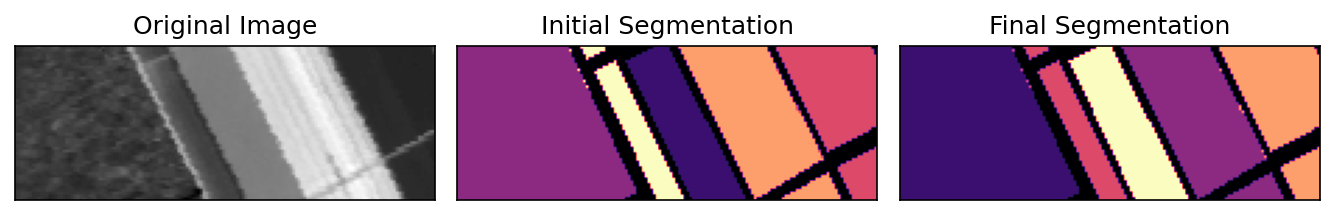

In [35]:
#Adaptive Superpixel Cuts
preprocessing_pipeline = Preprocesser.Preprocesser(data = hyperspectral_cube)
#preprocessing_pipeline.gaussian_blur(blur_param = 0)
preprocessing_pipeline.singular_value_decomposition(n_svd = 5)
preprocessing_pipeline.layer_normalization()
hyperspectral_cube = preprocessing_pipeline.data.copy()
original_hyperspectral_cube = preprocessing_pipeline.original_data.copy()
print('Preprocessed')

n_superpixels = 250 #2500
slic_m_param = 2  #2
assignments, centers = superpixel.generate_SLIC_assignments(data = hyperspectral_cube,
                                                            n_superpixels = n_superpixels,
                                                            slic_m_param = slic_m_param,
                                                            verbose=True)
superpixeled_cube, superpixel_library = superpixel.generate_SLIC_superpixels(data = hyperspectral_cube,
                                                                             assignments = assignments)
n_superpixels = len(np.unique(assignments))
print('Created Superpixels')

sigma_param = 0.005 # 0.1 -> 0.001           #0.01
spatial_limit = 10# 15 -> 25 in steps of 5 #15
spatial_beta_param = 0.0025
spatial_dmax_param = spatial_limit
ne = 5#number of endmembers

labelled_img, normalized_signatures, int_results = normalized_cuts.graph_regularized_ncuts_admm(data=hyperspectral_cube,
                                                                                                superpixel_library=superpixel_library,
                                                                                                superpixel_centers=centers,
                                                                                                superpixel_assignments=assignments,
                                                                                                n_endmembers = ne,
                                                                                                spectral_sigma2_param= sigma_param,
                                                                                                spatial_kappa_param=spatial_limit,
                                                                                                spatial_beta_param= spatial_beta_param,
                                                                                                spatial_dmax_param = spatial_dmax_param,
                                                                                                n_unmixing_iters = 200,
                                                                                                spectral_metric='SAM')

original_library  = segmentation_evaluation.calc_mean_label_signatures(utility.cube_to_matrix(original_hyperspectral_cube),
                                                                        labelled_img.reshape(-1))
print('Performed Segmentation')

fig, ax = plt.subplots(1,3, dpi=150);
ax[0].imshow(hyperspectral_cube[:,:,20], cmap = 'gray');
ax[1].imshow((int_results['initial_labels']+1)*(ground_truth != 0), cmap = 'magma');
ax[2].imshow((labelled_img+1)*(ground_truth != 0), cmap = 'magma');

ax[0].set_title("Original Image");
ax[1].set_title("Initial Segmentation");
ax[2].set_title("Final Segmentation");

ax[0].set_xticks([]);
ax[0].set_yticks([]);
ax[1].set_xticks([]);
ax[1].set_yticks([]);
ax[2].set_xticks([]);
ax[2].set_yticks([]);
plt.tight_layout();

KMEANS

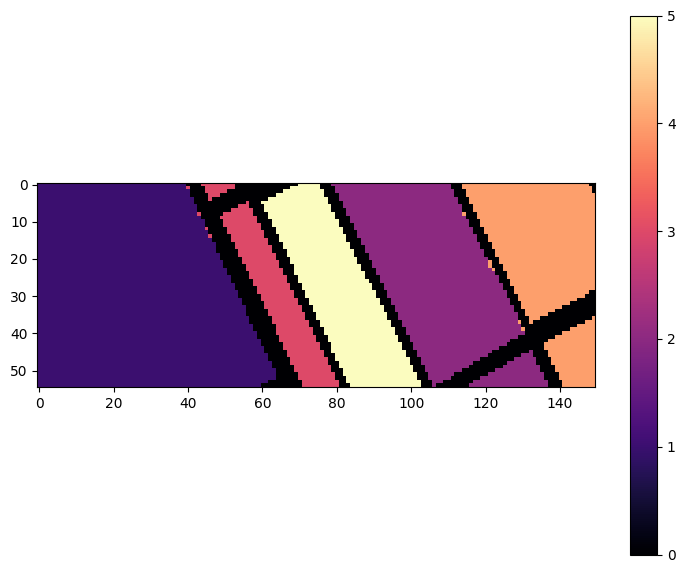

In [37]:
plt.imshow((labelled_img+1)*(ground_truth != 0), cmap = 'magma');
plt.colorbar();

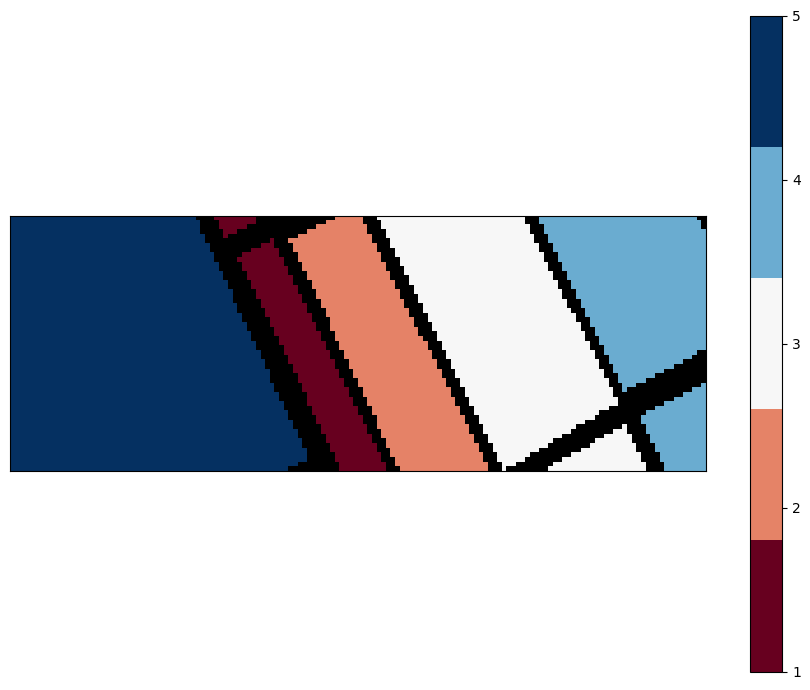

In [30]:
plt.imshow(np.ma.masked_where(ground_truth == 0, ground_truth), cmap=cmap)
plt.colorbar(ticks = np.arange(np.unique(ground_truth).shape[0] + 1));
plt.xticks([]);
plt.yticks([]);

plt.tight_layout();

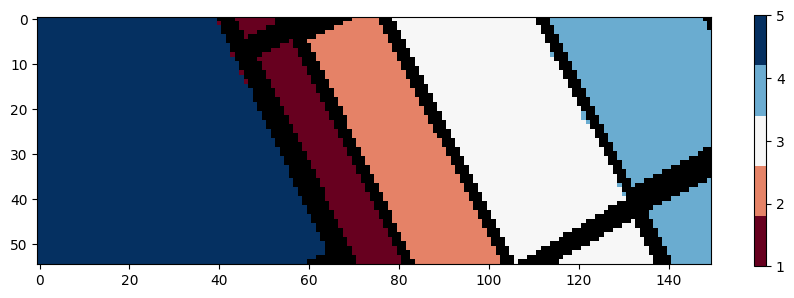

In [45]:
label_map = {   
            0 : 0,
            1 : 5 ,
            2 : 3,
            3 : 1,
            4 : 4,
            5 : 2
        }
final_alg_output = np.vectorize(lambda x: label_map[x])((labelled_img + 1)*(ground_truth != 0))

plt.imshow(np.ma.masked_where(final_alg_output == 0, final_alg_output), cmap = cmap)

plt.colorbar(ticks = np.arange(np.unique(ground_truth).shape[0] + 1), shrink = 0.375)
plt.tight_layout();

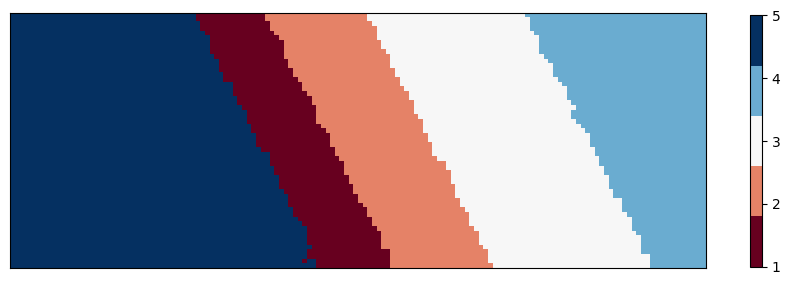

In [41]:
# label_map = {   
#             0 : 0,
#             1 : 5 ,
#             2 : 3,
#             3 : 1,
#             4 : 4,
#             5 : 2
#         }
# final_alg_output = np.vectorize(lambda x: label_map[x])((labelled_img+1))

# plt.imshow(np.ma.masked_where(final_alg_output == 0, final_alg_output), cmap = cmap)
# c
# plt.xticks([]);
# plt.yticks([]);

# plt.tight_layout();

In [46]:
import sklearn.metrics as skm
cfm = skm.confusion_matrix(ground_truth.reshape(-1),final_alg_output.reshape(-1), labels = np.unique(ground_truth))[1:, 1:]

In [47]:
def calculate_iou(confusion_matrix):
  """
  Calculates Intersection over Union (IoU) for each class in a confusion matrix.

  Args:
      confusion_matrix (numpy.ndarray): The confusion matrix.

  Returns:
      numpy.ndarray: Array containing IoU values for each class.
  """
  true_positives = np.diag(confusion_matrix)  # Extract diagonal elements (true positives)
  # Calculate total predicted positives (sum of each row) and total ground truth positives (sum of each column)
  predicted_positives = np.sum(confusion_matrix, axis=0)
  ground_truth_positives = np.sum(confusion_matrix, axis=1)
  # Avoid division by zero (set to 0 for IoU in such cases)
  iou = np.true_divide(true_positives, predicted_positives + ground_truth_positives - true_positives, where=(predicted_positives + ground_truth_positives - true_positives) != 0)
  return iou

# Example usage (assuming you have a confusion matrix named 'cm')
iou_per_class = calculate_iou(cfm)

In [48]:
np.concatenate([cfm, (np.diag(cfm) / np.sum(cfm, axis=1)).reshape(-1,1),iou_per_class.reshape(-1,1) ] , axis = 1)

array([[ 490.        ,    0.        ,    0.        ,    0.        ,    0.        ,    1.        ,    0.99190283],
       [   0.        ,  989.        ,    0.        ,    0.        ,    0.        ,    1.        ,    1.        ],
       [   0.        ,    0.        , 1621.        ,    6.        ,    0.        ,    0.99631223,    0.99631223],
       [   0.        ,    0.        ,    0.        , 1127.        ,    0.        ,    1.        ,    0.99470432],
       [   4.        ,    0.        ,    0.        ,    0.        , 2887.        ,    0.9986164 ,    0.9986164 ]])

In [40]:
np.diag(cfm).sum()/cfm.sum()

0.9985962942167321

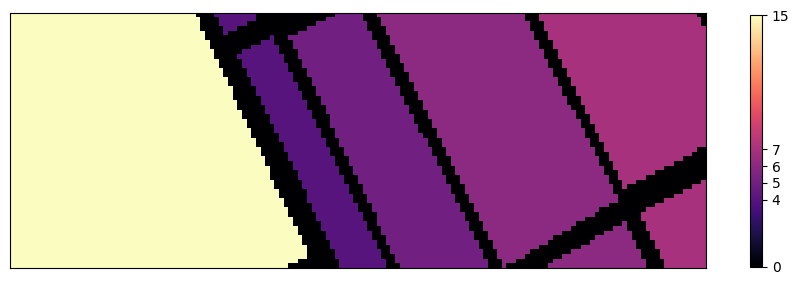

In [48]:

a = plt.imshow(ground_truth, cmap = 'magma');
plt.colorbar(a, ticks=np.unique(ground_truth)c);
plt.xticks([]);
plt.yticks([]);
plt.tight_layout();

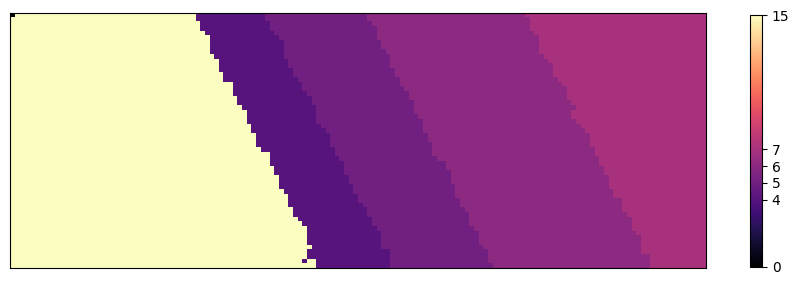

In [47]:
final_alg_output = np.vectorize(lambda x: label_map[x])((labelled_img+1))
final_alg_output[0,0] = 0
a = plt.imshow(final_alg_output, cmap = 'magma');
plt.colorbar(a, ticks=np.unique(final_alg_output), shrink=0.375);
plt.xticks([]);
plt.yticks([]);
plt.tight_layout();

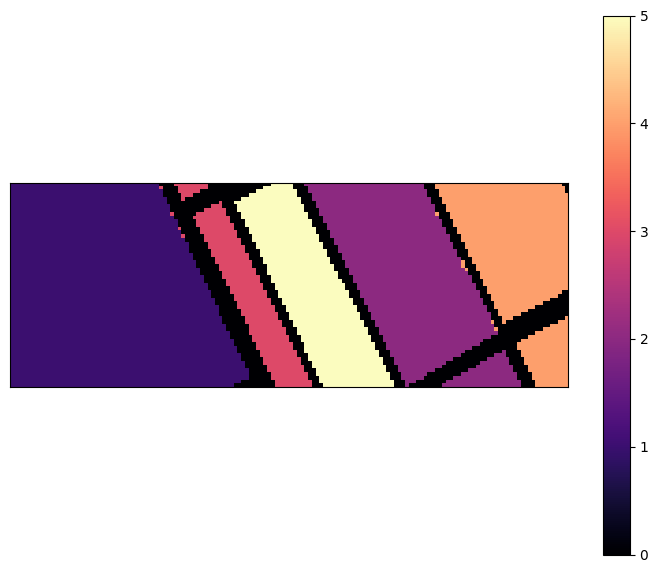

In [24]:
plt.imshow((labelled_img+1)*(ground_truth != 0), cmap = 'magma');
plt.xticks([]);
plt.yticks([]);
plt.colorbar();